In [3]:
# importing packages
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import wrds

import PyBondLab as pbl

In [4]:
# =============================================================================
# Option 1: access data directly from WRDS
# =============================================================================
# Assumes you have a valid WRDS account and have set-up your cloud access #
# See:
# https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/python-wrds-cloud/
wrds_username = '' # Input your WRDS username
db = wrds.Connection(wrds_username = wrds_username )

tbl1 = db.raw_sql("""SELECT  DATE, ISSUE_ID,CUSIP, RATING_NUM, RET_L5M,AMOUNT_OUTSTANDING,
                                TMT, N_SP, PRICE_L5M                         
                        FROM wrdsapps.bondret
                  """)
# # # Required because the WRDS data comes with "duplicates" in the index
# # # does not affect data, but the "index" needs to be re-defined #                 
tbl1 = tbl1.reset_index()
tbl1['index'] = range(1,(len(tbl1)+1))

# =============================================================================
# Option 2: Load any bond dataset you have saved to file
# =============================================================================
file = '' # Input your file name, assumed to be saved as .csv #
tbl1         =  pd.read_csv(file)

tbl1['index'] = range(1,(len(tbl1)+1))


# =============================================================================


In [5]:
# Format the data
tbl1.columns = tbl1.columns.str.upper()
tbl1['date'] = pd.to_datetime(tbl1['DATE'])
tbl1['AMOUNT_OUTSTANDING'] = np.abs(tbl1['AMOUNT_OUTSTANDING'])
tbl1['PRICE_L5M'] = np.abs(tbl1['PRICE_L5M'])
tbl1 = tbl1.sort_values(['ISSUE_ID','DATE'])

# WRDS data "starts" officially on "2002-08-31"
tbl1 = tbl1[tbl1['date'] >= "2002-08-31"]
tbl1 = tbl1[tbl1['date'] <= "2023-07-31"]

# Column used for value weigted returns
tbl1['VW'] = (tbl1['PRICE_L5M'] * tbl1['AMOUNT_OUTSTANDING'])/1000

N = len(np.unique(tbl1["ISSUE_ID"]))
ID = dict(zip(np.unique(tbl1["ISSUE_ID"]).tolist(),np.arange(1,N+1)))
tbl1["ISSUE_ID"] = tbl1["ISSUE_ID"].apply(lambda x: ID[x]) 

# renaming. could be skipped but then specify the ID and Ret variable in the .fit() method
# rename your primary bond identifier (i.e., ISSUE_ID or CUSIP) as simply "ID"
# rename your return variable to 'ret'
# rename your price variable to 'PRICE'
tbl1.rename(columns={"PRICE_L5M":"PRICE","ISSUE_ID":"ID","RET_L5M":"ret"},inplace=True)

Initialize the strategy. We use the Momentum class from the PyBondLab module. 
We construct two different momentum strategies in the spirit of Jegadeesh Titman (1993), with holding period of 3 and 6 months and formation period of 3 and 6 months. The momentum signal is constructed skipping the most recent observatio.

In [6]:
n_portf = 10
skip    = 1

mom33 = pbl.Momentum(K = 3,J = 3, skip = skip ,nport = n_portf) 
mom66 = pbl.Momentum(K = 6,J = 6, skip = skip ,nport = n_portf) 

-----------------------------------
Initializing Momentum (3,3) strategy (single sort):
Holding period: 3 
Number of portfolios: 10 
Sorting on: past returns
-----------------------------------
-----------------------------------
Initializing Momentum (6,6) strategy (single sort):
Holding period: 6 
Number of portfolios: 10 
Sorting on: past returns
-----------------------------------


params1 and params2 build two momentum strategies without applying any filtering, using only non-investment grade bonds.

params3 and params4 build two momentum strategies as before but with trimming the right tail of the distribution of returns at 20%


In [7]:
params1 = {'strategy':mom33,'rating':"NIG"}
params2 = {'strategy':mom66,'rating':"NIG"}

params3 = {'strategy':mom33,'rating':"NIG",
                'filters': {'adj':'trim','level': 0.9},
                }   
params4 = {'strategy':mom66,'rating':"NIG",
                'filters': {'adj':'trim','level': 0.9},
                }   

Now we construct the strategies.

In [8]:
data1 = tbl1.copy()
data2 = tbl1.copy()
data3 = tbl1.copy()
data4 = tbl1.copy()

RES1 = pbl.StrategyFormation(data1, **params1).fit()
RES2 = pbl.StrategyFormation(data2, **params2).fit()
RES3 = pbl.StrategyFormation(data3, **params3).fit()
RES4 = pbl.StrategyFormation(data4, **params4).fit()

MOMENTUM
MOMENTUM
MOMENTUM
MOMENTUM


plotting

<Axes: title={'center': 'Equally-weighted cumulative performance'}, xlabel='Date', ylabel='Value ($)'>

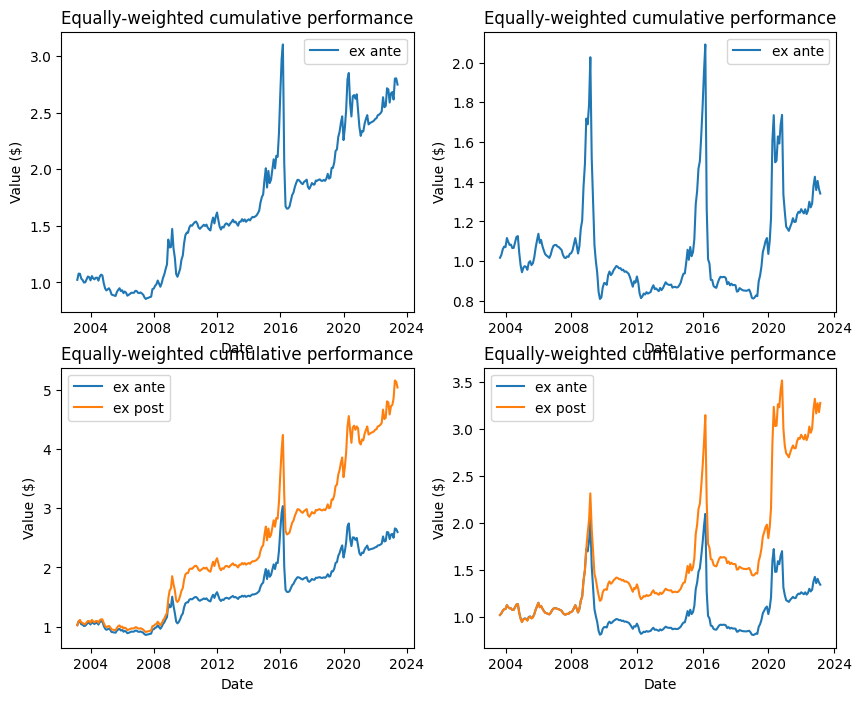

In [9]:
fig,axs = plt.subplots(2,2,figsize=(10,8))

RES1.plot(ax=axs[0, 0])
RES2.plot(ax=axs[0, 1])
RES3.plot(ax=axs[1, 0])
RES4.plot(ax=axs[1, 1])

Computing expected returns for the long short strategies 

In [10]:
index = pd.MultiIndex.from_product([['Ex Ante', 'Ex Post'], ['Avg Ret(%)', 't-stat']], names=['Type', 'Statistic'])
columns = ['Mom(3,3)', 'Mom(6,6)', 'Mom(3,3) trimmed', 'Mom(6,6) trimmed']
ret = pd.DataFrame(index=index, columns=columns)

list_res = [RES1,RES2,RES3,RES4]

idx = 0   # 1 for value weighted
nw_lag = 3

for i, r in enumerate(list_res):
    y = r.get_long_short()[idx] 
    mod = sm.OLS(y,np.ones_like(y),missing='drop').fit(cov_type='HAC',
                             cov_kwds={'maxlags': nw_lag})
    param = mod.params.squeeze()*100
    tstat = mod.tvalues.squeeze()
    ret.loc[('Ex Ante', 'Avg Ret(%)'), columns[i]] = param
    ret.loc[('Ex Ante', 't-stat'), columns[i]] = tstat
    if i >1:
        #get ex post as well
        yy = r.get_long_short_ex_post()[idx]
        mod_ep = sm.OLS(yy,np.ones_like(yy),missing='drop').fit(cov_type='HAC',
                             cov_kwds={'maxlags': nw_lag})
        param_ep = mod_ep.params.squeeze()*100
        tstat_ep = mod_ep.tvalues.squeeze()
        ret.loc[('Ex Post', 'Avg Ret(%)'), columns[i]] = param_ep
        ret.loc[('Ex Post', 't-stat'), columns[i]] = tstat_ep

ret =ret.apply(pd.to_numeric).round(3)
ret

Mom(3,3)  Mom(6,6)  Mom(3,3) trimmed  Mom(6,6) trimmed
Type    Statistic                                                         
Ex Ante Avg Ret(%)     0.520     0.315             0.498             0.316
        t-stat         1.647     0.639             1.551             0.640
Ex Post Avg Ret(%)       NaN       NaN             0.750             0.650
        t-stat           NaN       NaN             2.419             1.399